# Use transfer-learning with huggingface-transformers library

## Load data and make it accessible for huggingface environment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import transformers
from transformers import (AutoTokenizer, 
                          TFAutoModel,
                          TFAutoModelForSequenceClassification
                          )
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset # to use huggingface datasets
from detector.utils import load_data, divide_frame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks, Model
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from joblib import dump, load

transformers.utils.logging.set_verbosity_error()

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tf.config.list_physical_devices() # to see if GPU is available

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [452]:
# Load gpt3 outputs from huggingface (output is from gpt3-curie model)
gpt_simple = load_dataset('aadityaubhat/GPT-wiki-intro')
gpt_simple.set_format(type='pandas')
df_gpt3 = pd.DataFrame(columns=['text', 'AI'])
df_gpt3['text'] = gpt_simple['train']['generated_intro']
df_gpt3['AI'] = 1
df_gpt3["version"] = "gpt3"
df_gpt3.to_csv("gpt3_output/gpt3_simple.csv", index=False)
df_gpt3.reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


,text,AI,version
0,Sexhow railway station was a railway station l...,1,gpt3
1,"In Finnish folklore, all places and things, an...",1,gpt3
2,"In mathematics, specifically differential calc...",1,gpt3
3,is a Japanese shōjo manga series written and i...,1,gpt3
4,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",1,gpt3
...,...,...,...
149995,Randy Borum is a Professor and Coordinator of ...,1,gpt3
149996,"Sa'och (, also, ""Sauch"") is an endangered, nuc...",1,gpt3
149997,Philip C. Hanawalt (born 1931) is an American ...,1,gpt3
149998,Vossius Gymnasium is a public gymnasium in the...,1,gpt3


In [453]:
# data I created using the OpenAI API (approx. 23_600 samples)
df_gpt3_advanced = pd.read_csv("gpt3_output/gpt3_advanced.csv")

In [454]:
df_gpt3_advanced["version"] = "gpt3.5" # add version to later analyze on which outputs the model performs better
df_gpt3_advanced

,text,AI,version
0,Washington D.C. - In the midst of a polarizing...,1,gpt3.5
1,Science: The Key to Our Future\n\nScience has ...,1,gpt3.5
2,Local High School Wins State Championship in B...,1,gpt3.5
3,Mathematics: More Than Just Numbers\n\nMathema...,1,gpt3.5
4,Tragic Car Accident Claims Three Lives\n\nIn a...,1,gpt3.5
...,...,...,...
23649,The educational system of Germany\n\nGermany i...,1,gpt3.5
23650,The educational system in Finland is often tou...,1,gpt3.5
23651,Education is an essential aspect of any societ...,1,gpt3.5
23652,The educational system of Germany is one of th...,1,gpt3.5


In [387]:
data = load_data() # load original data originate from OpenAI with human text and GPT2 outputs

In [465]:
train, val, test = (data["train"].reset_index(drop=True), 
                    data["valid"].reset_index(drop=True), 
                    data["test"].reset_index(drop=True))


def remove_newline(text: str) -> str:
    return text.replace("\n", " ")

for df in [train, val, test]:
    df["version"] = np.where(df["AI"] ==1, "gpt2", "human")
    
for df in [train, val, test, df_gpt3, df_gpt3_advanced]:
    df["text"] = df["text"].apply(remove_newline)
    df["text_length"] = df['text'].apply(len)

In [466]:
# sample all data but with no order (which is due to the fact how I called the OpenAI API to retrieve the data)
df_gpt3_advanced = df_gpt3_advanced.sample(frac=1,random_state=1).reset_index(drop=True)
df_gpt3_advanced

,text,AI,version,text_length
0,"Generative AI, also known as creative AI, is a...",1,gpt3.5,1605
1,Science: Advancements and Discoveries in the F...,1,gpt3.5,2301
2,The education system of Finland is known as on...,1,gpt3.5,1177
3,Sports have been an integral part of human soc...,1,gpt3.5,674
4,Tragic Car Accident Claims Three Lives On Fri...,1,gpt3.5,1071
...,...,...,...,...
23649,Artificial intelligence (AI) has seen tremendo...,1,gpt3.5,661
23650,Title: Local High School Wins State Championsh...,1,gpt3.5,1865
23651,Generative AI Revolutionizes Creative Industri...,1,gpt3.5,1061
23652,Introduction: Education is one of the crucial...,1,gpt3.5,1135


In [467]:
# add gpt3 outputs to the original data
train = pd.concat([train, df_gpt3.iloc[:140_000, :], df_gpt3_advanced.iloc[:-5000,:]])
val = pd.concat([val, df_gpt3.iloc[140_000:145_000,:], df_gpt3_advanced.iloc[-5000:-2500,:]])
test = pd.concat([test, df_gpt3.iloc[145_000:,:], df_gpt3_advanced.iloc[-2500:,:]])

In [6]:
train_size = 70_000

In [470]:
# sample data to have 50 % human text and 50 % AI text where AI text is divided into 25 % gpt2, 25 % gpt3, 50 % gpt3.5
train_sample = pd.concat(
                    [train[train.version == "human"].sample(n=train_size//2, random_state=1),
                    train[train.version == "gpt2"].sample(n=train_size//8, random_state=1),
                    train[train.version == "gpt3"].sample(n=train_size//8, random_state=1),
                    train[train.version == "gpt3.5"].sample(n=train_size//4, random_state=1)]
                    ).reset_index(drop=True)
val = pd.concat([val[val.version == "human"].sample(5000, random_state=1),
                 val[val.version == "gpt2"].sample(1250, random_state=1),
                 val[val.version == "gpt3"].sample(1250, random_state=1),
                 val[val.version == "gpt3.5"].sample(2500, random_state=1)]).reset_index(drop=True)
test = pd.concat([test[test.version == "human"].sample(5000, random_state=1),
                 test[test.version == "gpt2"].sample(1250, random_state=1),
                 test[test.version == "gpt3"].sample(1250, random_state=1),
                 test[test.version == "gpt3.5"].sample(2500, random_state=1)]).reset_index(drop=True)

In [471]:
# just to have a look at the data
display(train_sample)
display(val)
display(test)

,text,AI,version,text_length
0,drereichdude's Thoughts: This is one of my fa...,0,human,1714
1,Duration (Minutes)When current flows through w...,0,human,572
2,# !/usr/bin/env python ''' NAME ghc-coloriz...,0,human,3126
3,I think Azure Logic Apps is a great way to imp...,0,human,4309
4,Recipe for a vegan Falafel Burger with avocado...,0,human,3989
...,...,...,...,...
69995,Machine learning is an exciting field of compu...,1,gpt3.5,1091
69996,Mathematics is a fundamental subject that has ...,1,gpt3.5,716
69997,"Mathematics, often referred to as the language...",1,gpt3.5,2075
69998,Sports have been a fundamental aspect of human...,1,gpt3.5,818


,text,AI,version,text_length
0,"Behold, a virgin shall conceive, and bear a so...",0,human,3807
1,"John Fetterman, center, the mayor of Braddock,...",0,human,4486
2,Who is Alec Torelli? Alec Torelli has a uniqu...,0,human,543
3,The year is 2084. If you somehow survived the ...,0,human,1136
4,"AUSTIN, United States — ""Rejections."" That's w...",0,human,4788
...,...,...,...,...
9995,Opening shot of a computer screen with code ru...,1,gpt3.5,1884
9996,Introduction: Machine learning is a subset of...,1,gpt3.5,1171
9997,Title: The Beauty of Mathematics Opening shot...,1,gpt3.5,1834
9998,Introduction: Machine learning is a field of ...,1,gpt3.5,1131


,text,AI,version,text_length
0,Researchers over at Check Point Security have ...,0,human,2540
1,Glass et al. (1989) reported a 16-year-old boy...,0,human,4196
2,(You may have been directed here from www.ke0o...,0,human,1111
3,This tournament is a 1v1 Joust where everyone ...,0,human,1816
4,"Grand Prize - $100,000 The M-Prize Winner is ...",0,human,309
...,...,...,...,...
9995,Generative AI: The Future of Artificial Intell...,1,gpt3.5,2283
9996,Title: Local High School Takes Home Championsh...,1,gpt3.5,2108
9997,Introduction: Politics is an arena that is fi...,1,gpt3.5,2165
9998,Innovative Education System in Finland Finlan...,1,gpt3.5,2367


In [473]:
# check the data counts
val.version.value_counts()

version
human     5000
gpt3.5    2500
gpt2      1250
gpt3      1250
Name: count, dtype: int64

In [407]:
# train_small, train_medium, train_long = divide_frame(train)
# for df in [train_small, train_medium, train_long]:
#     print(df.shape[0])

# train_sample = pd.concat([train_small.sample(20_000, random_state=1), 
#                           train_medium.sample(30_000, random_state=1),
#                           train_long.sample(20_000, random_state=1)]).reset_index(drop=True)

In [474]:
# create Dataset objects from the dataframes to use them with the huggingface library
ds_train = Dataset.from_pandas(train_sample, split="train")
ds_val = Dataset.from_pandas(val, split="valid")
ds_test = Dataset.from_pandas(test, split="test")

In [475]:
# pack datasets into a dictionary to tokenize them in parallel
ds_dict = DatasetDict({"train": ds_train, "valid": ds_val, "test": ds_test})

In [476]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
})

In [477]:
# save the data to disk (not needed when already done)
ds_dict.save_to_disk(f"preprocessed_data_{train_size}")

In [7]:
# load the data from disk (to save time when running the notebook again)
ds_dict = load_from_disk(f"preprocessed_data_{train_size}")
ds_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length'],
        num_rows: 10000
    })
})

## Create Tokenizer suitable for the model

In [140]:
def model_checkpoint(name: str="distilbert", 
                     large: bool=True,
                     uncased: bool=True) -> str:
    model_ckpt = f'{name}-large' if large else f'{name}-base'
    return f'{model_ckpt}-uncased' if uncased else model_ckpt

model_ckpt = model_checkpoint(name="roberta",large=True, uncased=False)
# define the tokenizer the model was trained with
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.save_pretrained(f"extractors_tokenizer_{model_ckpt}") # faster for prediction
#model_ckpt

('extractors_tokenizer_roberta-large/tokenizer_config.json',
 'extractors_tokenizer_roberta-large/special_tokens_map.json',
 'extractors_tokenizer_roberta-large/vocab.json',
 'extractors_tokenizer_roberta-large/merges.txt',
 'extractors_tokenizer_roberta-large/added_tokens.json',
 'extractors_tokenizer_roberta-large/tokenizer.json')

In [9]:
tokenizer("this is a test!", return_tensors="tf") # just to see how the tokenizer works

2023-06-25 20:07:15.670406: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-06-25 20:07:15.671630: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-25 20:07:15.671657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-25 20:07:15.672105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-25 20:07:15.673813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[   0, 9226,   16,   10, 1296,  328,    2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [10]:
tokenizer.model_input_names # to see what the model expects as input

['input_ids', 'attention_mask']

In [482]:
# define a tokenize function that tokenizes the text in batches
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [483]:
# encode the data; only run when not yet done
ds_encoded = ds_dict.map(tokenize, batched=True, batch_size=10_000)

In [484]:
# save the encoded data to disk (not needed when already done)
ds_encoded.save_to_disk(f"encoded_data_{train_size}")

In [11]:
# load data from disk (to save time when running the notebook again)
ds_encoded = load_from_disk(f"encoded_data_{train_size}")

## Option 1: Use pre-trained model as feature extractor

### Extracting last hidden layer of a BERT model

For this approach the model-weights of our RoBERTA model are frozen and provide features for a classifier 

In [143]:
# choose model to use from huggingface
model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True) # load the model from the checkpoint
model.save_pretrained(f"extractors_model_{model_ckpt}") # save model on disk to predict faster

In [13]:
# just a test
text = "this is a test"
inputs = tokenizer(text, return_tensors="tf")
outputs = model(**inputs)
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 6, 1024), dtype=float32, numpy=
array([[[ 0.04603524, -0.00462841,  0.01070017, ..., -0.05166832,
          0.10207281,  0.06168523],
        [ 0.16665468, -0.10331246, -0.35997272, ...,  0.06356603,
         -0.1478664 ,  0.08259304],
        [ 0.36435974, -0.06037583, -0.32145458, ...,  0.09165369,
          0.07294382,  0.12116899],
        [-0.08846132, -0.09831417,  0.01492194, ..., -0.04664286,
         -0.18895282,  0.1724447 ],
        [ 0.07978453, -0.15301354, -0.12229724, ..., -0.16046473,
          0.11752793,  0.00620504],
        [ 0.06696582, -0.0087914 ,  0.03385552, ..., -0.0685569 ,
          0.08994152,  0.01962573]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.15439375,  0.71824986,  0.45034176, ..., -0.00599452,
         0.40904945, -0.3544111 ]], dtype=float32)>, past_key_values=None, hidden_states=None, attentions=None, cross_at

In [14]:
outputs.last_hidden_state.shape #output [batch_size, n_tokens, hidden_dim]

TensorShape([1, 6, 1024])

In [15]:
# for classification it is common practice use hidden state associated to start 
# of sequence token
outputs.last_hidden_state[:, 0].shape 

TensorShape([1, 1024])

In [16]:
# extract last hidden state for whole dataset
def extract_hidden_states(batch):
    inputs = {k: v for k,v in batch.items() if k in tokenizer.model_input_names}
    last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].numpy()}

In [17]:
ds_encoded.set_format("tensorflow", columns=["input_ids", "attention_mask", "AI"])

In [18]:
extract_hidden_states(ds_encoded["train"][:2]) # just a test

{'hidden_state': array([[-0.3427664 , -0.28302005, -0.21823733, ...,  0.21029028,
         -0.7165592 ,  0.48414364],
        [-0.3774553 , -0.19625072, -0.10798267, ...,  0.48125118,
         -0.23683989,  0.46917036]], dtype=float32)}

In [492]:
# extract all hidden states for the whole dataset (takes long; only run when not yet done)
# GPU recommended!
ds_hidden = ds_encoded.map(extract_hidden_states, batched=True, batch_size=50)

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [493]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

In [494]:
# save to disk the hidden states for reuse
ds_hidden.save_to_disk(f"hidden_states_{model_ckpt}_{train_size}")

In [19]:
# load hidden states from disk (to save time when running the notebook again)
ds_hidden = load_from_disk(f"hidden_states_{model_ckpt}_{train_size}")

In [20]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 70000
    })
    valid: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'version', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

In [88]:
# shuffling data (not needed, just wanted to make sure that models do not learn from the order of the data)
ds_hidden_train_shuffled = ds_hidden["train"].shuffle(seed=1)
ds_hidden_val_shuffled = ds_hidden["valid"].shuffle(seed=1)
ds_hidden_test_shuffled = ds_hidden["test"].shuffle(seed=1)

In [114]:
# just to check it works
ds_hidden_val_shuffled[:3]

{'AI': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 1, 0])>,
 'input_ids': <tf.Tensor: shape=(3, 512), dtype=int64, numpy=
 array([[    0,    20,    22, ...,   172,    24,     2],
        [    0,   510, 31497, ...,  2452,     8,     2],
        [    0, 34447,    42, ...,     1,     1,     1]])>,
 'attention_mask': <tf.Tensor: shape=(3, 512), dtype=int64, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]])>,
 'hidden_state': <tf.Tensor: shape=(3, 1024), dtype=float32, numpy=
 array([[-0.21136746, -0.06436478, -0.35749552, ...,  0.27449238,
         -0.48374236,  0.42047864],
        [-0.2226051 , -0.1944612 , -0.14720827, ...,  0.33875376,
         -0.49206942,  0.38407058],
        [-0.15701647, -0.30564892, -0.19805235, ...,  0.19279474,
         -0.17367943,  0.42932492]], dtype=float32)>}

-----

### Preparing data to train model

We are now using these hidden states to train a relatively simple classifier to predict if text is AI written or not.

In [92]:
X_train = np.array(ds_hidden_train_shuffled["hidden_state"])
X_val = np.array(ds_hidden_val_shuffled["hidden_state"])
X_test = np.array(ds_hidden_test_shuffled["hidden_state"])

y_train = np.array(ds_hidden_train_shuffled["AI"])
y_val = np.array(ds_hidden_val_shuffled["AI"])
y_test = np.array(ds_hidden_test_shuffled["AI"])

In [21]:
# X_train = np.array(ds_hidden["train"]["hidden_state"])
# X_val = np.array(ds_hidden["valid"]["hidden_state"])
# X_test = np.array(ds_hidden["test"]["hidden_state"])

# y_train = np.array(ds_hidden["train"]["AI"])
# y_val = np.array(ds_hidden["valid"]["AI"])
# y_test = np.array(ds_hidden["test"]["AI"])

In [93]:
X_train

array([[-0.53308034, -0.23917353, -0.30839637, ...,  0.21083452,
        -0.2365539 ,  0.4096494 ],
       [-0.23844111, -0.16399954, -0.1715692 , ...,  0.334796  ,
        -0.490215  ,  0.57703674],
       [-0.06416402, -0.16005722, -0.13072658, ...,  0.36260733,
        -0.2638023 ,  0.50358015],
       ...,
       [-0.36641166, -0.20664789, -0.10559689, ...,  0.44444257,
        -0.5690878 ,  0.4653337 ],
       [-0.35671422, -0.17738439, -0.10524814, ...,  0.24413244,
        -0.35898906,  0.5773676 ],
       [-0.26076144, -0.20022778, -0.13960727, ...,  0.46314907,
        -0.32893983,  0.5128594 ]], dtype=float32)

In [94]:
X_train.shape, y_train.shape

((70000, 1024), (70000,))

In [95]:
X_search = np.vstack((X_train, X_val))
y_search = np.hstack((y_train, y_val))

In [97]:
print(X_search.shape, y_search.shape)
split = PredefinedSplit([-1]*X_train.shape[0]+[0]*X_val.shape[0])

(80000, 1024) (80000,)


In [98]:
scores_model_roberta = {}

### Logistic Regression

In [99]:
lr_clf = LogisticRegression(max_iter=3000)

params = {"C":[2**k for k in range(2, 12)]}

search = GridSearchCV(lr_clf,
                      param_grid=params,
                      n_jobs=-1,
                      cv = split,
                      scoring="accuracy")

In [100]:
search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(max_iter=3000), n_jobs=-1,
             param_grid={'C': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]},
             scoring='accuracy')

In [107]:
search.best_params_

{'C': 32}

In [108]:
lr_clf_best = LogisticRegression(max_iter=5000, C=search.best_params_["C"])

In [109]:
lr_clf_best.fit(X_train, y_train)

LogisticRegression(C=32, max_iter=5000)

In [110]:
dump(lr_clf_best, f"trained_models_{train_size}/lr_clf_best_{model_ckpt}.joblib")

['trained_models_70000/lr_clf_best_roberta-large.joblib']

In [111]:
lr_clf_best = load(f"trained_models_{train_size}/lr_clf_best_{model_ckpt}.joblib")

In [112]:
scores_model_roberta["logistic_regression"] = lr_clf_best.score(X_test, y_test)
scores_model_roberta["logistic_regression"]

0.9623

### SVM Classifier

In [38]:
#from sklearn.svm import SVC

In [39]:
# svc = SVC(random_state=1)

# params_svc = {
#     'C': [0.5, 1, 2],
#     #'degree': 3,
#     'kernel': ['linear']
#  }

# search_svc = GridSearchCV(
#     svc,
#     param_grid=params_svc,
#     n_jobs=-1,
#     cv=split,
#     scoring="accuracy"
# )

In [40]:
# search_svc.fit(X_search, y_search)

In [41]:
# search_svc.best_score_

In [42]:
# svc_best = search_svc.best_estimator_

In [43]:
# svc_best.fit(X_train, y_train)

In [44]:
# svc_best.score(X_test, y_test)

### Random Forest Classifier

In [45]:
#from sklearn.ensemble import RandomForestClassifier

In [46]:
#rf_clf = RandomForestClassifier(random_state=1, verbose=1, n_jobs=-1)

In [47]:
# params_rf = {
#  'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]
#  }

# random_search = RandomizedSearchCV(rf_clf,
#                                    param_distributions=params_rf,
#                                    n_iter=5,
#                                    scoring="accuracy",
#                                    n_jobs=-1,
#                                    cv=split)

In [85]:
# random_search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features=

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy')

In [48]:
#random_search.best_score_

### Gradient Boosting

In [ ]:
# from xgboost import XGBClassifier
# xgb_clf = XGBClassifier(booster = 'gblinear', 
#                         n_estimators=1000, 
#                         seed=1, 
#                         random_state=1)
# #xgb_clf.get_params()
# params_xgb = {
#     'reg_lambda': [k*0.1 for k in range(15)]
#     }

# search_xgb = GridSearchCV(
#     xgb_clf,
#     param_grid=params_xgb,
#     n_jobs=-1,
#     cv=split,
#     scoring="accuracy"
# )

In [29]:
# search_xgb.fit(X_search, y_search)

In [140]:
# xgb_best = search_xgb.best_estimator_

In [141]:
# xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [142]:
# dump(xgb_best, f"trained_models/xgb_best_{model_ckpt}.joblib.dat")

['trained_models/xgb_best_roberta-large.joblib.dat']

In [143]:
# scores_model_roberta["xgb"] = xgb_best.score(X_test, y_test)

In [144]:
# scores_model_roberta["xgb"]

0.9368

### Ridge Classification

In [115]:
from sklearn.linear_model import RidgeClassifierCV

In [116]:
ridge_clf = RidgeClassifierCV(alphas=[0.03, 0.035, 0.04, 0.045], cv=split)

ridge_clf.fit(X_search, y_search)

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.52917e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.5494e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.37585e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/linea

RidgeClassifierCV(alphas=[0.03, 0.035, 0.04, 0.045],
                  cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])))

In [117]:
ridge_clf.best_score_

0.9602

In [118]:
dump(ridge_clf, f"trained_models_{train_size}/ridge_clf_{model_ckpt}.joblib")

['trained_models_70000/ridge_clf_roberta-large.joblib']

In [119]:
scores_model_roberta["ridge"] = ridge_clf.score(X_test, y_test)

In [120]:
scores_model_roberta["ridge"]

0.9591

### Simple NN

In [47]:
nn_inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation='gelu', kernel_initializer="he_normal")(nn_inputs)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='gelu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
nn_model = Model(inputs=nn_inputs, outputs = outputs, name="basic_nn")
nn_model.summary()

Model: "basic_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 69825 (272.75 KB)
Trainable params: 69825 (272.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
num_epochs = 150
num_train_examples = X_train.shape[0]
batch_size = 32
init_lr = 1e-3

decay_steps = num_train_examples // batch_size

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr,
                                                    decay_steps=decay_steps,
                                                    decay_rate=0.9)

es = callbacks.EarlyStopping(monitor="val_binary_accuracy",
                             mode="max",
                             patience=10,
                             restore_best_weights=True)

nn_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[keras.metrics.BinaryAccuracy()],
                 optimizer = optimizers.legacy.Adam(lr_schedule))

In [50]:
history = nn_model.fit(X_train, y_train,
             batch_size=batch_size,
             epochs=num_epochs,
             validation_data=(X_val, y_val),
             callbacks=[es])

Epoch 1/150


/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-25 20:24:18.089832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.2278 - binary_accuracy: 0.9043

2023-06-25 20:25:06.268232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 52s 23ms/step - loss: 0.2278 - binary_accuracy: 0.9043 - val_loss: 0.1564 - val_binary_accuracy: 0.9339
Epoch 2/150
2188/2188 [==============================] - 42s 19ms/step - loss: 0.1565 - binary_accuracy: 0.9367 - val_loss: 0.1611 - val_binary_accuracy: 0.9345
Epoch 3/150
2188/2188 [==============================] - 44s 20ms/step - loss: 0.1367 - binary_accuracy: 0.9456 - val_loss: 0.1278 - val_binary_accuracy: 0.9538
Epoch 4/150
2188/2188 [==============================] - 41s 19ms/step - loss: 0.1233 - binary_accuracy: 0.9513 - val_loss: 0.1448 - val_binary_accuracy: 0.9389
Epoch 5/150
2188/2188 [==============================] - 45s 20ms/step - loss: 0.1130 - binary_accuracy: 0.9560 - val_loss: 0.1543 - val_binary_accuracy: 0.9384
Epoch 6/150
2188/2188 [==============================] - 43s 19ms/step - loss: 0.1066 - binary_accuracy: 0.9579 - val_loss: 0.0982 - val_binary_accuracy: 0.9624
Epoch 7/150
2188/2188 [=======================

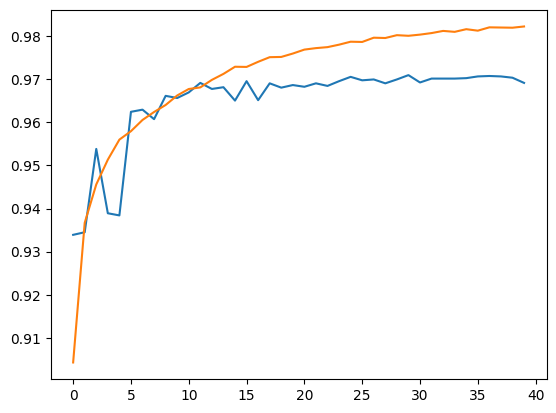

In [51]:
plt.plot(history.history["val_binary_accuracy"])
plt.plot(history.history["binary_accuracy"]);

In [52]:
scores_model_roberta["neural_network"] = nn_model.evaluate(X_test, y_test)[1]
scores_model_roberta["neural_network"]

313/313 [==============================] - 2s 5ms/step - loss: 0.0899 - binary_accuracy: 0.9687


0.9686999917030334

In [53]:
nn_model.save(f"nn_model_{model_ckpt}_{train_size}")

INFO:tensorflow:Assets written to: nn_model_roberta-large_70000/assets


INFO:tensorflow:Assets written to: nn_model_roberta-large_70000/assets


## Get Prediction for input text

In [58]:
scores_model_roberta

{'logistic_regression': 0.9624,
 'ridge': 0.9591,
 'neural_network': 0.9686999917030334}

In [132]:
test_text = ds_dict["test"]["text"][5]
print(test_text)
nn_model.predict(model(**tokenizer(test_text, return_tensors='tf')).last_hidden_state[:,0].numpy())[0][0]
#ridge_clf.decision_function(model(**tokenizer(test_text, return_tensors='tf')).last_hidden_state[:,0].numpy())

Super GT (stylized as SUPER GT) is a grand touring car racing series that began in 1993. Originally titled as the Zen Nihon GT Senshuken (全日本GT選手権), generally referred to as either the JGTC or the All Japan Grand Touring Car .... the Nissan Skyline GT-R, the Toyota Supra, and the Honda NSX represented their ...
1/1 [==============================] - 0s 64ms/step


0.15542404

In [152]:
def get_prediction(text_input: str, 
                   model_ckpt: str="distilbert-base-uncased",
                   train_size: int=70_000,
                   model_name: str="nn") -> tuple[float, str]:
    '''outputs the probability of the text being AI written
    ---
    text_input: text to be classified
    ---
    model_ckpt: model to be used for feature extraction. Options are "distilbert"
    and "roberta".
    ---
    model_name: model to be used for classification. Options are "nn" 
    for neural network, "lr" for logistic regression, "ridge" for ridge classifier.
    '''
    # instantiate tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(f"extractors_tokenizer_{model_ckpt}")
    model = TFAutoModel.from_pretrained(f'extractors_model_{model_ckpt}')
    # extract features
    inputs = tokenizer(text_input.replace("\n", " "), return_tensors="tf")
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    # choose model for classification and return prediction and probability
    proba = None
    class_pred = None
    if model_name == "nn":
        nn_model = keras.models.load_model(f"nn_model_{model_ckpt}_{train_size}")
        proba = nn_model.predict(hidden_states, verbose=0)[0][0]
    elif model_name == "lr":
        lr_clf_best = load(f"trained_models_{train_size}/lr_clf_best_{model_ckpt}.joblib")
        proba = lr_clf_best.predict_proba(hidden_states)[0][1]
    elif model_name == "ridge":
        ridge_clf = load(f"trained_models_{train_size}/ridge_clf_{model_ckpt}.joblib")
        decision = ridge_clf.decision_function(hidden_states)[0]
        proba = np.exp(decision)/(1+np.exp(decision)) # be careful with this (probabilities are not calibrated)
    # elif model_name == "xgb": # xgboost takes too much CPU and RAM
    #     xgb_best = load(f"trained_models/xgb_best_{model_ckpt}.joblib.dat")
    #     proba = xgb_best.predict_proba(hidden_states)[0][1]
    else:
        raise ValueError("model must be one of 'nn', 'lr' or 'ridge'")
    if proba > 0.5:
        class_pred = "AI written"
    else:
        class_pred = "not AI written"
    print(f'Probability of text being AI written: {proba:.2f}. \nThe prediction therfore is that the text is {class_pred}.')
    return proba, class_pred

In [153]:
get_prediction(test_text, model_ckpt="roberta-large", 
               train_size = 70000, model_name="nn")

Probability of text being AI written: 0.16. 
The prediction therfore is that the text is not AI written.


2023-06-26 15:53:14.510001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(0.15542404, 'not AI written')

In [154]:
demo = pd.read_csv("gpt3_output/demo_data.csv")
demo

,text,AI
0,Headline: Political Tensions Rise as Election ...,1
1,"In the current political climate, tensions are...",1
2,"In a heated political scene, tensions rise as ...",1
3,In the midst of a tumultuous political climate...,1
4,"In the midst of a global pandemic, politics co...",1
...,...,...
245,The educational system of Finland has been wid...,1
246,"Recently, there has been a lot of attention on...",1
247,Sweden's Educational System: A Model for the W...,1
248,"In recent years, the educational system of Fin...",1


In [156]:
get_prediction(demo.text[25], model_ckpt="roberta-large",
               train_size=70000, model_name="nn")

Probability of text being AI written: 1.00. 
The prediction therfore is that the text is AI written.


2023-06-26 16:22:07.153137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(0.9999782, 'AI written')